**About** : Exploration

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

## Initialization

### Imports

In [3]:
import os
import gc
import ast
import sys
import cv2
import glob
import json
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from utils.plots import *
from utils.metrics import iou_map
from utils.rle import rles_to_mask_fix
from utils.logger import prepare_log_folder, create_logger, save_config

from data.preparation import prepare_extra_data
from data.dataset import SartoriusDataset
from data.transforms import define_pipelines, to_mosaic

from training.main import k_fold
from inference.post_process import *

In [5]:
import mmdet
import mmdet.models
from mmcv import Config

from mmcv.utils import build_from_cfg
from mmdet.datasets.builder import PIPELINES
from mmdet.datasets.pipelines import Compose

## Preprocessing

In [6]:
annotations = glob.glob(DATA_PATH + "LIVECell_dataset_2021/annotations/LIVECell_single_cells/*/*.json")
annotations = []  # do not recompute

In [7]:
SHSY5Y_ONLY = False
NO_SHSY5Y = True
SINGLE_CLASS = False

name = "livecell.csv"
classes = LIVECELL_CLASSES

if SHSY5Y_ONLY:
    annotations = [a for a in annotations if "shsy5y" in a]
    name = "livecell_shsy5y.csv"
elif NO_SHSY5Y:
    annotations = [a for a in annotations if "shsy5y" not in a]
    name = "livecell_no_shsy5y.csv"
    classes = ['', '', ''] + LIVECELL_CLASSES[:-1]

if SINGLE_CLASS:
    assert NO_SHSY5Y
    name = "livecell_no_shsy5y_single.csv"

In [8]:
metas = []
for path in tqdm(annotations):
    filename = path.split('/')[-1]
    _, cell_type, split = filename.split('.')[0].split('_')
    print(f"\n -> Processing {cell_type}_{split}")
    annots = json.load(open(path, 'r'))
    
    annots["annotations"] = list(annots["annotations"].values())
    coco = COCO()
    coco.dataset = annots
    coco.createIndex()

    cell_index = -1 if SHSY5Y_ONLY else classes.index(cell_type.lower())
    cell_index = 3 if SINGLE_CLASS else cell_index
    
    for image in annots['images']:
        
        boxes, rles = [], []
        for annot in coco.anns.values():
            if annot['image_id'] == image['id']:
                rles.append(coco.annToRLE(annot))
                
                box = np.array(annot["bbox"])
                box[2] += box[0]
                box[3] += box[1]
                boxes.append(box)
        
        meta = {
            'filename': image['file_name'],
            'width': image['width'],
            'height': image['height'],
            'cell_type': cell_type,
            'split': split,
            'ann': {
                'bboxes': np.array(boxes).astype(int).tolist(),
                'labels': [cell_index] * len(boxes),
                'masks': rles
            }
        }
        metas.append(meta)
        
#     break

if len(metas):
    meta_df = pd.DataFrame.from_dict(metas)
    meta_df.to_csv(OUT_PATH + name, index=False)
    
    print(f' -> Saved to "{OUT_PATH + name}"')
    
    sns.countplot(x=meta_df['cell_type'])

## Data

In [9]:
class Config:
    """
    Parameters used for training
    """
    # Images
    use_mosaic = False
    use_tta = False  # TODO
    data_config = "data/config_mosaic.py" if use_mosaic else "data/config.py"
#     data_config = "data/config_rescale.py"

In [10]:
df = prepare_extra_data(name="livecell")
# df = prepare_extra_data(name="livecell_shsy5y")

In [11]:
pipelines = define_pipelines(Config.data_config)

In [12]:
dataset = SartoriusDataset(df, pipelines['val_viz'], precompute_masks=False)

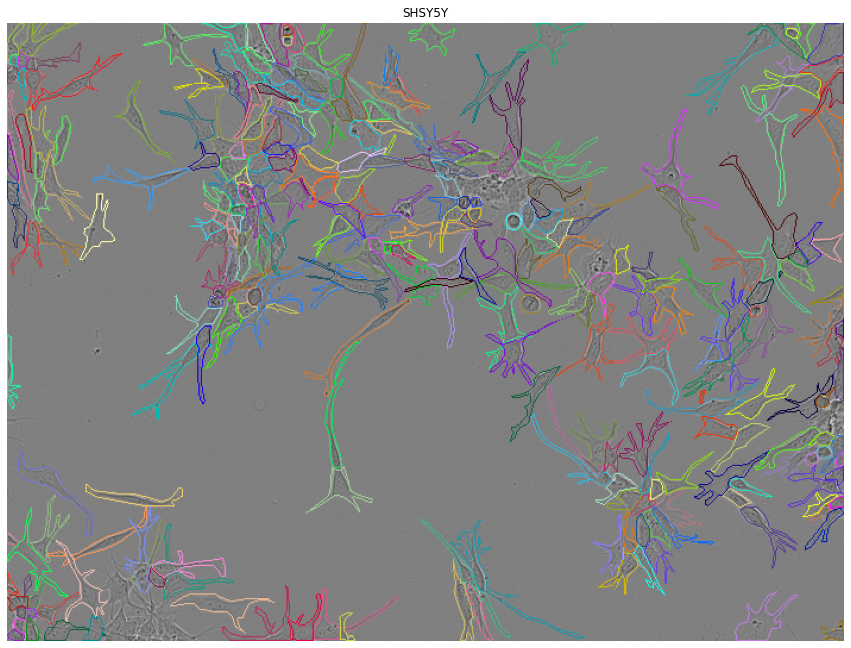

In [13]:
for idx in range(10):
    idx = np.random.choice(len(dataset))

    data = dataset[idx]

    img = data['img']
    boxes = data['gt_bboxes']

    plt.figure(figsize=(15, 15))
    plot_sample(img, data['gt_masks'], plotly=False)
    plt.title(df['cell_folder'][idx])
    plt.axis(False)
    plt.show()
    
    break

## Training

In [14]:
from training.main import train

def pretrain(config, log_folder=None):
    """
    Pretrains a model.
    TODO

    Args:
        config (Config): Parameters.
        log_folder (None or str, optional): Folder to logs results to. Defaults to None.
    """
    df = prepare_extra_data(name="livecell")

    skf = StratifiedKFold(n_splits=config.k, shuffle=True, random_state=config.random_state)
    splits = list(skf.split(X=df, y=df["cell_type"]))

    all_results = []

    for i, (train_idx, val_idx) in enumerate(splits):
        df_train = df.iloc[train_idx].copy().reset_index(drop=True)
        df_val = df.iloc[val_idx].copy().reset_index(drop=True)

        pipelines = define_pipelines(config.data_config)

        results = train(
            config, df_train, df_val, pipelines, i, log_folder=log_folder, precompute_masks=False
        )
        all_results += results

        return all_results


In [15]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    first_epoch_eval = 10
    compute_val_loss = False
    verbose_eval = 5

    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # Images
    fix = True
    extra_name = ""
    use_extra_samples = False
    num_classes = 8

    use_mosaic = False
    use_tta = False  # TODO
    data_config = "data/config_mosaic.py" if use_mosaic else "data/config.py"

    # k-fold
    k = 50
    random_state = 0
    selected_folds = [0] #, 1, 2, 3, 4]

    # Model
    name = "cascade"  # "cascade"
    encoder = "swin_small"
    model_config = f"model_zoo/config_{name}.py"
    pretrained_livecell = False
    
    if name == "htc":
        data_config = "data/config_semantic.py"

    # Training
    optimizer = "Adam"
    scheduler = "plateau" if optimizer == "SGD" else "linear"
    weight_decay = 0.0001 if optimizer == "SGD" else 0
    batch_size = 3
    val_bs = batch_size

    epochs = 8

    lr = 3e-4
    warmup_prop= 0.05

    use_fp16 = False  # TODO

In [16]:
DEBUG = False
log_folder = None

In [17]:
LOG_PATH = "../logs/pretrain/"

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder)
    create_logger(directory=log_folder, name="logs.txt")

results = pretrain(Config, log_folder=log_folder)

Logging results to ../logs/pretrain/2021-11-26/1/

 -> Loading weights from ../input/weights/cascade_mask_rcnn_swin_small_patch4_window7.pth

    -> 5279 training images
    -> 108 validation images
    -> 101768100 trainable parameters

Epoch 01/08 	 lr=2.8e-04	 t=2130s	loss=2.919
Epoch 02/08 	 lr=2.4e-04	 t=2167s	loss=2.082
Epoch 03/08 	 lr=2.0e-04	 t=2181s	loss=1.891
